## Dataset 

In [39]:
import os
import numpy as np 
import matplotlib.pyplot as plt
import json
import cv2
import torch
import pycocotools.mask as mask_util
import shutil
from pycocotools import mask as coco_mask
import matplotlib.patches as patch
from matplotlib.patches import Polygon

In [3]:
with open("test_renamed.json","r") as f:
    data = json.load(f)

image_path = "./images/"

In [4]:
## Total number of images present in images folder
print(f"Total number of images = {len(os.listdir(image_path))}")

Total number of images = 3303


In [5]:
annotations = data["annotations"]
images = data["images"]
categories = data["categories"]

In [6]:
categories

[{'id': 1, 'name': 'Solar', 'type': 2},
 {'id': 2, 'name': 'PV', 'type': 2},
 {'id': 3, 'name': 'Roof_Terrace', 'type': 2},
 {'id': 4, 'name': 'Dormer', 'type': 2},
 {'id': 5, 'name': 'Roof_Windows', 'type': 2},
 {'id': 6, 'name': 'Chimneys', 'type': 2},
 {'id': 7, 'name': 'Wintergarden', 'type': 2},
 {'id': 8, 'name': 'Unknown_Class_', 'type': 2}]

In [7]:
# total number of images in annotation Json
print(len(images))
images[4]

433


{'id': 5,
 'file_name': 'bayern_DEBYvAAAAAASi9rl_0_5609bb90-c608-4338-9a53-af2fddc023a0.image_dop_10_400000.png',
 'height': 500,
 'width': 500,
 'tag_ids': [4, 5],
 'url': ''}

In [8]:
# total number of annotations 
print(len(annotations))
annotations[0].keys()

6610


dict_keys(['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox', 'iscrowd'])

In [10]:
# Number of images with ID in JSON with corresponding annotations
im_in_annotations = []
for i,d in enumerate(images):
    im_in_annotations.append(d["file_name"])

print(len(im_in_annotations))

433


In [11]:
# Number of images present in ./images directory have annotation files
count = 0
missing =0
for im in os.listdir(image_path):
    if im in im_in_annotations:
        count +=1
    else:
        missing +=1

print(count)
print(missing)

433
2870


In [13]:
image_ids = [] # image ids in annotations
for i,di in enumerate(annotations):
    image_ids.append(di["image_id"])
    
print(len(image_ids)) # number of annotations
training_ids = np.unique(image_ids)
print(len(training_ids)) # number of image ids with annotations

train_split = int(len(training_ids)*0.8) # 80%
val_split = int(len(training_ids)*0.15) # 15%
test_split = int(len(training_ids)*0.05) #5%

train_samples = training_ids[0:train_split]
val_samples = training_ids[train_split:train_split+val_split]
test_samples = training_ids[train_split+val_split:train_split+val_split+test_split]

print("Samples for training splits :",round(train_split)) 
print("Samples for val split :", round(val_split))
print("Samples for test split :", round(test_split)) 

6610
406
Samples for training splits : 324
Samples for val split : 60
Samples for test split : 20


In [21]:
def rle_to_mask(rle, shape,scaled=False):
    mask = coco_mask.frPyObjects(rle, shape[1], shape[0])
    mask = coco_mask.decode(mask)
    if scaled:
        mask = cv2.resize(mask, None, fx=2, fy=2, interpolation=cv2.INTER_NEAREST) ## use for scaling the mask 2x
    return mask

In [20]:
def mask_to_polygon(maskedArr):
    contours, _ = cv2.findContours(maskedArr, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    segmentation = []
    for contour in contours:
        if contour.size >= 6:
            segmentation.append(contour.flatten().tolist())
    return segmentation[0]

In [19]:
def rle_to_polygon(rle,shape,scaled=False):
    scale_shape = (int(shape[0]),int(shape[1])) if not scaled else (int(shape[0]/2),int(shape[1]/2))
    bit_mask = rle_to_mask(rle,scale_shape,scaled) ##divide for scaled mask
    s = mask_to_polygon(bit_mask)
    segment =  (np.array(s).reshape(-1, 2) / np.array([shape[0], shape[1]])).reshape(-1).tolist()
    return segment

In [18]:
def bbox_yolo_normalised(bbox,img_width,img_height):
    box = np.array(bbox, dtype=np.float64)
    box[:2] += box[2:] / 2  
    box[[0, 2]] /= img_width
    box[[1, 3]] /= img_height 
    return list(box)

In [22]:
def create_yolotxt(split,labels_path,split_ids,annotations_json,images_json,scaled=False):
    with open(f"{split}.txt","w") as split_file:
        for ids in split_ids:
            file_name = [im["file_name"] for im in images_json if im["id"] ==ids]
            if file_name[0] not in os.listdir(f"./images/{split}/"):
                shutil.copy(f"./images/{file_name[0]}",f"./images/{split}")
            txt_path = os.path.join(labels_path,f"{file_name[0].rsplit('.',1)[0]}.txt")
            with open(txt_path,"w") as txt:
                for d in annotations_json:
                    if d["image_id"] == ids:
                        if scaled:
                            w = d['segmentation']['size'][0]*2
                            h = d['segmentation']['size'][1]*2
                            cat_id = d['category_id']-1
                            bbox_yolo = bbox_yolo_normalised([i*2 for i in d['bbox']],w,h)
                            segments = rle_to_polygon(d['segmentation'],(h,w))
                        else:
                            w = d['segmentation']['size'][0]
                            h = d['segmentation']['size'][1]
                            cat_id = d['category_id']-1
                            bbox_yolo = bbox_yolo_normalised(d['bbox'],w,h)
                            segments = rle_to_polygon(d['segmentation'],(h,w),scaled)
                        txt.write(f"{cat_id} {' '.join(map(str,bbox_yolo))} {' '.join(map(str,segments))}\n")
            txt.close()
            split_file.write(f"{str(os.path.join(f'./images/{split}/',file_name[0]))}"+'\n')#,{txt_path}\n")

create_yolotxt("test","./labels/test/",test_samples,annotations,images)
create_yolotxt("train","./labels/train/",train_samples,annotations,images)
create_yolotxt("val","./labels/val/",val_samples,annotations,images)

In [23]:
def overlay(image, mask, alpha):
    color = np.array([255,0,0], dtype='uint8')
    mask = np.round(mask)
    masked_img = np.where(mask[...,None], color, image)
    image_combined = cv2.addWeighted(image, 1-alpha, masked_img, alpha, 0)
    return image_combined

In [24]:
def xywhn2xyxy(x, w, h, padw=0, padh=0):
    # Convert nx4 boxes from [x, y, w, h] normalized to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y =  np.copy(x)
    y[0] = w * (x[0] - x[2] / 2) + padw  # top left x
    y[1] = h * (x[1] - x[3] / 2) + padh  # top left y
    y[2] = w * (x[0] + x[2] / 2) + padw  # bottom right x
    y[3] = h * (x[1] + x[3] / 2) + padh  # bottom right y
    return y

In [25]:
def xywh2xyxy(x):
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y =  np.copy(x)
    y[0] = x[0] - x[2] / 2  # top left x
    y[1] = x[1] - x[3] / 2  # top left y
    y[2] = x[0] + x[2] / 2  # bottom right x
    y[3] = x[1] + x[3] / 2  # bottom right y
    return y

In [26]:
def xyn2xy(x, w, h, padw=0, padh=0):
    # Convert normalized segments into pixel segments, shape (n,2)
    y = np.copy(x)
    segments = (y.reshape(-1, 2)*np.array([w, h])).reshape(-1).tolist()
    return segments

In [27]:
def polygon2mask(img_size, polygons, color=1, downsample_ratio=1):
   
    mask = np.zeros(img_size, dtype=np.uint8)
    polygons = np.asarray(polygons)
    polygons = polygons.astype(np.int32)
    shape = polygons.shape
    polygons = polygons.reshape(-1, 2)
    cv2.fillPoly(mask, [polygons], color=color)
    nw, nh = (img_size[0] // downsample_ratio, img_size[1] // downsample_ratio)
    mask = cv2.resize(mask, (nw, nh))
    return mask

(500, 502, 3)


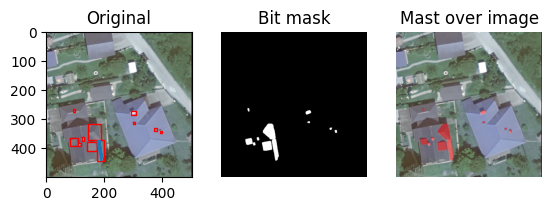

In [40]:

def visualize_annotations(split_text,labels_folder):
    fig,(ax,ax1,ax2) = plt.subplots(1,3)
    sample = open(split_text,"r").readlines()[0].split("\n")[0] 

    labels = open(os.path.join(labels_folder,sample.rsplit(".",1)[0].split("/")[-1])+".txt","r").readlines() 
    im = cv2.imread(sample)
    print(im.shape)
    im_height = im.shape[0]
    im_width = im.shape[1]
    ax.imshow(im)
    ms =[]
    poly =[]
    masks = np.zeros((im_height, im_width))
    anno=[]
    for i in range(0,len(labels)):
        anno = list(map(float,labels[i].split(" ")))
        box_coord = anno[1:5]
        label = anno[:0]

        box_coord_xyxy = xywhn2xyxy(box_coord,im_width,im_height)
        
        rext = patch.Rectangle((box_coord_xyxy[0],box_coord_xyxy[1]),box_coord_xyxy[2]-box_coord_xyxy[0],box_coord_xyxy[3]-box_coord_xyxy[1],facecolor='none', \
                            edgecolor="r")
        binary_masks = polygon2mask((im_width,im_height),xyn2xy(anno[5:],im_width,im_height))
        ax.add_patch(rext)
        masks +=binary_masks
        ms.append(binary_masks)
        poly.append(xyn2xy(anno[5:],im_width,im_height))
        
    ax1.imshow(masks,cmap='grey')
        
    alpha_channel = 1-masks
    rgbs_image = overlay(im, masks, alpha=0.5)
    ax2.imshow(rgbs_image)
    poly = poly[6]
    p = [[poly[i],poly[i+1]] for i in range(0,len(poly),2)] 
    polygon1 = Polygon(p)
    ax.add_patch(polygon1)
    ax.set_title("Original") # with bounding boxes and polygon
    ax1.set_title("Bit mask")
    ax2.set_title("Mast over image")
    ax1.axis("off")
    ax2.axis("off")

visualize_annotations("./train.txt","./labels/train/")


(1000, 1004, 3)


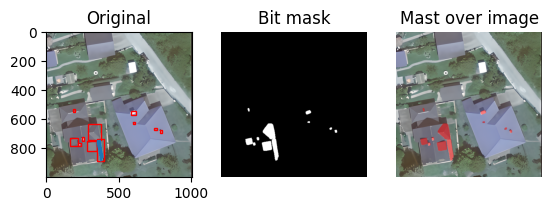

In [41]:
visualize_annotations("./train_scaled.txt","./labels/train_scaled/")
